In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg as LA
import datetime
from scipy.linalg import orthogonal_procrustes
import json
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression


######## EDIT THIS #####
net = 'highd_inputs'
tasks = np.concatenate((range(6),range(11,20)))
act = 'softplus'
untrained = False
model_n = 0

if act == 'relu':
    dir_set = ['lowD/combos/most','lowD/grad_norm_l2h000001/most','lowD/grad_norm_l2001/most'] 
else:
    dir_set = ['crystals/softplus/no_reg','crystals/softplus/l2h00001','crystals/softplus/l2w0001']

dir_specific = 'crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/'#'crystals/softplus/no_noise' #dir_set[1]
titles = ['context','stim1','go1']
#########################

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import procrustes_fit, procrustes_test, prep_procrustes,pca_denoise,get_model_params, gen_trials_from_model_dir, name_best_ckpt, make_procrustes_mat_stim, gen_X_from_model_dir_epoch

fldr = os.path.join('procrustes_analysis/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

display_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Integration1', 'Integration2', 'CxtIntegration1', 'CxtIntegration2', 'MultiIntegration',
              'MemoryIntegration1', 'MemoryIntegration2', 'CxtMemoryInt1', 'CxtMemoryIntegration2', 'MultiMemoryIntegration',
              'MemoryMatchSample', 'MemoryMatchSampleNogo', 'MemoryCategoryGo', 'MemoryCategoryNoGo']

rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']


model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific,str(model_n))
if untrained is True:
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-1')
else:
    ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(model_dir_all, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in tasks:
    c = cmap(r/20)
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rules_dict['all'][r]])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
plt.show()

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 500x500 with 1 Axes>

In [6]:

def procrustes_test(mtx1, mtx2, R, s):
    # transform mtx2 to minimize disparity
    mtx2 = np.dot(mtx2, R.T) * s

    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))

    return mtx1, mtx2, disparity

def make_procrustes_mat_stim(model_dir_all,ckpt_n_dir,epoch,tasks,nD = 10):
    
    procrust = {}
    procrust['Disparity'] = np.zeros((len(tasks),len(tasks)))
    procrust['Scaling'] = np.zeros((len(tasks),len(tasks)))
    
    rule = 'delaygo'
    trial_all = gen_trials_from_model_dir(model_dir_all,rule)
    trial_all_test = gen_trials_from_model_dir(model_dir_all,rule)

    for t1_ind in range(len(tasks)):
        t1 = tasks[t1_ind]

        trial1 = same_stim_trial(trial_all, t1)
        X1,_ = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1,epoch)

        trial1_test = same_stim_trial(trial_all_test, t1)
        X1_test,_ = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1_test,epoch)

        for t2_ind in range(len(tasks)):
            if t1_ind !=t2_ind:
                t2 = tasks[t2_ind]

                trial2 = same_stim_trial(trial_all, t2)
                X2,_ = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial2,epoch)
                X1_pca,X2_pca = pca_denoise(X1,X2,nD)
                prep_mtx1, prep_mtx2 = prep_procrustes(X1_pca,X2_pca)
                _, _, disparity_train, R, s = procrustes_fit(prep_mtx1, prep_mtx2)

                trial2_test = same_stim_trial(trial_all_test, t2)
                X2_test,_ = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial2_test,epoch)
                X1_pca_test,X2_pca_test = pca_denoise(X1_test,X2_test,nD)
                prep_mtx1_test, prep_mtx2_test = prep_procrustes(X1_pca_test,X2_pca_test)
                mtx1, mtx2, disparity_test = procrustes_test(prep_mtx1_test, prep_mtx2_test, R, s)

                procrust['Disparity'][t1_ind,t2_ind] = disparity_test
                procrust['Scaling'][t1_ind,t2_ind] = s
    return procrust

def align_output_inds(trial_master, trial_temp):

    indices = range(np.shape(trial_master.y_loc)[1])
    n_out = np.shape(trial_master.y)[2]-1

    for ii in range(np.shape(trial_master.y_loc)[1]):
        if np.max(np.sum(abs(trial_master.x[:,ii,1:(1+n_out)]),axis = 1),axis = 0)>0:
            ind_use = np.max(np.sum(abs(trial_temp.x[:,:,1:(1+n_out)]),axis = 2),axis = 0)>0
        else:
            ind_use = np.max(np.sum(abs(trial_temp.x[:,:,(1+n_out):(1+2*n_out)]),axis = 2),axis = 0)>0

        loc_diff = abs(trial_temp.y_loc[-1,:]-trial_master.y_loc[-1,ii])%(2*np.pi)
        align_ind = [int(i) for i, x in enumerate(loc_diff) if x == min(loc_diff)]
        align_ind_choosey = [x for i, x in enumerate(align_ind) if ind_use[x]]
        if len(align_ind_choosey)==0:
            align_ind_choosey = align_ind
        indices[ii] = align_ind_choosey[npr.randint(len(align_ind_choosey))]
    
    trial_temp_new = trial_temp
    trial_temp_new.x = trial_temp_new.x[:,indices,:]
    trial_temp_new.y = trial_temp_new.y[:,indices,:]
    trial_temp_new.y_loc = trial_temp_new.y_loc[:,indices]
    return trial_temp_new

def project_to_output(model_dir_all,X):
    w_in, b_in, w_out, b_out = get_model_params(model_dir_all)
    y = np.dot(X.T, w_out) + b_out
    return y

def gen_mov_x(model_dir_all,ckpt_n_dir,rule,trial_master):
    trial = gen_trials_from_model_dir(model_dir_all,rule)
    trial = align_output_inds(trial_master, trial)
    _,x = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial,'go1')
    x_out = project_to_output(model_dir_all,x[:,:,-1])
    err = np.sum(np.square(x_out[:,1:] - trial.y[-1,:,1:]),axis=1)
    return err, x

def make_procrustes_mat_mov(model_dir_all,ckpt_n_dir,epoch,tasks,nD = 10,err_lim = .2):
    
    procrust = {}
    procrust['Disparity'] = np.zeros((len(tasks),len(tasks)))
    procrust['Scaling'] = np.zeros((len(tasks),len(tasks)))
    
    rule_all = 'dmcgo'
    trial_all = gen_trials_from_model_dir(model_dir_all,rule_all)
    trial_all_test = gen_trials_from_model_dir(model_dir_all,rule_all)

    for t1_ind in range(len(tasks)):
        t1 = tasks[t1_ind]
        err1, x1 = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t1],trial_all)
        _, x1_test = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t1],trial_all_test)

        for t2_ind in range(len(tasks)):
            if t1_ind !=t2_ind:
                t2 = tasks[t2_ind]
                err2, x2 = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t2],trial_all)
                _, x2_test = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t2],trial_all_test)

                if ckpt_n_dir[-1]==str(1):
                    use_trials = np.multiply(err1>-err_lim,err2>-err_lim) #keep all trials
                else:
                    use_trials = np.multiply(err1<err_lim,err2<err_lim)

                if np.sum(use_trials)>8:
                    X2 = np.reshape(x2[:,use_trials,:15],(np.shape(x2)[0],-1))
                    X1 = np.reshape(x1[:,use_trials,:15],(np.shape(x1)[0],-1))

                    X2_test = np.reshape(x2_test[:,use_trials,:15],(np.shape(x2)[0],-1))
                    X1_test = np.reshape(x1_test[:,use_trials,:15],(np.shape(x1)[0],-1))
                else:
                    raise ValueError('Less than ' + str(np.sum(use_trials)) + ' trials to compare.')

                X1_pca,X2_pca = pca_denoise(X1,X2,nD)
                prep_mtx1, prep_mtx2 = prep_procrustes(X1_pca,X2_pca)
                _, _, disparity_train, R, s = procrustes_fit(prep_mtx1, prep_mtx2)

                X1_pca_test,X2_pca_test = pca_denoise(X1_test,X2_test,nD)
                prep_mtx1_test, prep_mtx2_test = prep_procrustes(X1_pca_test,X2_pca_test)
                mtx1, mtx2, disparity_test = procrustes_test(prep_mtx1_test, prep_mtx2_test, R, s)

                procrust['Disparity'][t1_ind,t2_ind] = disparity_test
                procrust['Scaling'][t1_ind,t2_ind] = s
    return procrust

def make_h_combined(model_dir_all,ckpt_n_dir,tasks,trial_set,n_steps_early = 5):
    
    h_context_combined = []
    h_stim_early_combined = []
    h_stim_late_combined = []
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        rule = 'delaygo'
        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
        
        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]
        time_set = [trial.epochs['stim1'][0]] #beginning of stim period
        n_stim_dims = np.shape(trial.x)[2]-20


        for r in range(len(tasks)):
            r_all_tasks_ind = tasks[r]
            
            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            # comparing Jacobians to proximity of hidden state across tasks
            # we focus on end of the context period, early, and late in the stim period
            h_context = np.reshape(h_tf[trial.epochs['stim1'][0]-1,trial_set,:],(1,-1)) # h @ end of context period
            h_stim_early = np.reshape(h_tf[trial.epochs['stim1'][0]+n_steps_early,trial_set,:],(1,-1)) # h @ 5 steps into stim
            h_stim_late = np.reshape(h_tf[trial.epochs['stim1'][1],trial_set,:],(1,-1)) # h @ end of stim period

            #concatenate activity states across tasks
            if h_context_combined == []:
                h_context_combined = h_context[np.newaxis,:]
                h_stim_late_combined = h_stim_late[np.newaxis,:]
                h_stim_early_combined = h_stim_early[np.newaxis,:]
            else:
                h_context_combined = np.concatenate((h_context_combined, h_context[np.newaxis,:]), axis=0)
                h_stim_late_combined = np.concatenate((h_stim_late_combined, h_stim_late[np.newaxis,:]), axis=0)
                h_stim_early_combined = np.concatenate((h_stim_early_combined, h_stim_early[np.newaxis,:]), axis=0)

    return h_context_combined, h_stim_late_combined, h_stim_early_combined

def make_Jac(model_dir_all,ckpt_n_dir,rule,task_set,time_set,trial_set):
    n_tasks = len(task_set)
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
        
        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        n_stim_dims = n_inputs - 20
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]

        #init mats
        J_np_u = np.zeros((n_tasks,len(trial_set),N,n_inputs))
        J_np_u_dot_delu = np.zeros((n_tasks,len(trial_set),N))
        eff_in = np.zeros((n_tasks,len(trial_set)))

        for r in range(n_tasks):
            r_all_tasks_ind = task_set[r]
            
            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            for trial_i in range(len(trial_set)): #depending on the analysis I was including one or many trials

                inputs = np.squeeze(trial.x[time_set,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                inputs = inputs[np.newaxis,:]

                states = h_tf[time_set,trial_set[trial_i],:]
                states = states[np.newaxis,:]
                
                #calc Jac wrt inputs
                inputs_context = np.squeeze(trial.x[time_set-1,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                inputs_context = inputs_context[np.newaxis,:]
                delta_inputs = inputs - inputs_context

                inputs_tf_context = tf.constant(inputs_context, dtype=tf.float32)
                states_tf = tf.constant(states, dtype=tf.float32)
                output, new_states = model.cell(inputs_tf_context, states_tf)
                F_context = new_states

                J_tf_u = pfor.batch_jacobian(F_context, inputs_tf_context, use_pfor=False)
                J_np_u[r,trial_i,:,:] = sess.run(J_tf_u)
                J_np_u_dot_delu[r,trial_i,:] = np.squeeze(np.dot(J_np_u[r,trial_i,:,:],delta_inputs.T))
                eff_in[r,trial_i] = LA.norm(J_np_u_dot_delu[r,trial_i,:])
                    
    return J_np_u_dot_delu, eff_in

def make_h_and_Jac(model_dir_all,ckpt_n_dir,rule,task_set,time_set,trial_set):

    h_context_combined = []
    h_stim_early_combined = []
    h_stim_late_combined = []
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
        
        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        n_stim_dims = n_inputs - 20
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]
        time_set = [trial.epochs['stim1'][0]] #beginning of stim period

        #init mats
        J_np_u = np.zeros((n_tasks,len(trial_set),len(time_set),N,n_inputs))
        J_np_u_dot_delu = np.zeros((n_tasks,len(trial_set),len(time_set),N))

        for r in range(n_tasks):
            r_all_tasks_ind = task_set[r]
            
            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            # comparing Jacobians to proximity of hidden state across tasks
            # we focus on end of the context period, early, and late in the stim period
            h_context = np.reshape(h_tf[trial.epochs['stim1'][0]-1,trial_set,:],(1,-1)) # h @ end of context period
            h_stim_early = np.reshape(h_tf[trial.epochs['stim1'][0]+n_steps_early,trial_set,:],(1,-1)) # h @ 5 steps into stim
            h_stim_late = np.reshape(h_tf[trial.epochs['stim1'][1],trial_set,:],(1,-1)) # h @ end of stim period

            #concatenate activity states across tasks
            if h_context_combined == []:
                h_context_combined = h_context[np.newaxis,:]
                h_stim_late_combined = h_stim_late[np.newaxis,:]
                h_stim_early_combined = h_stim_early[np.newaxis,:]
            else:
                h_context_combined = np.concatenate((h_context_combined, h_context[np.newaxis,:]), axis=0)
                h_stim_late_combined = np.concatenate((h_stim_late_combined, h_stim_late[np.newaxis,:]), axis=0)
                h_stim_early_combined = np.concatenate((h_stim_early_combined, h_stim_early[np.newaxis,:]), axis=0)

            for trial_i in range(len(trial_set)): #depending on the analysis I was including one or many trials
                for time_i in range(len(time_set)): #also including one or many time pts

                    inputs = np.squeeze(trial.x[time_set[time_i],trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs = inputs[np.newaxis,:]

                    states = h_tf[time_set[time_i],trial_set[trial_i],:]
                    states = states[np.newaxis,:]
                    
                    #calc Jac wrt inputs
                    inputs_context = np.squeeze(trial.x[time_set[time_i]-1,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs_context = inputs_context[np.newaxis,:]
                    delta_inputs = inputs - inputs_context

                    inputs_tf_context = tf.constant(inputs_context, dtype=tf.float32)
                    states_tf = tf.constant(states, dtype=tf.float32)
                    output, new_states = model.cell(inputs_tf_context, states_tf)
                    F_context = new_states

                    J_tf_u = pfor.batch_jacobian(F_context, inputs_tf_context, use_pfor=False)
                    J_np_u[r,trial_i,time_i,:,:] = sess.run(J_tf_u)
                    J_np_u_dot_delu[r,trial_i,time_i,:] = np.squeeze(np.dot(J_np_u[r,trial_i,time_i,:,:],delta_inputs.T))
                    
    return J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined

def same_stim_trial(trial_master, task_num):
    n_stim_per_ring = int(np.shape(trial_master.y)[2]-1)
    stim_rep_size = int(2*n_stim_per_ring+1)
    trial_task_num = trial_master
    trial_task_num.x[:,:,stim_rep_size:] = 0
    trial_task_num.x[:,:,stim_rep_size+task_num] = 1
    return trial_task_num


In [7]:
trial = gen_trials_from_model_dir(model_dir_all,'delaygo',mode='test')
n_total_trials = np.shape(trial.x)[1]# num trials in delaygo task
n_trials_use = n_total_trials
skip_trials = int(n_total_trials/n_trials_use)
#mod1 and mod2 are every other trial so we grab 8 trials from both groups spanning 360 stim angles
trial_set = np.concatenate((range(0,n_total_trials,skip_trials),range(1,n_total_trials,skip_trials)))

h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_combined(model_dir_all,ckpt_n_dir,tasks,trial_set)

# Distances across different tasks
dist = DistanceMetric.get_metric('euclidean')
X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
procrust = {}
epoch = titles[1]
procrust[epoch] = make_procrustes_mat_stim(model_dir_all,ckpt_n_dir,epoch,tasks)
epoch = titles[2]
procrust[epoch] = make_procrustes_mat_mov(model_dir_all,ckpt_n_dir,epoch,tasks,10)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:177: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradrisc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/ckpts/model.ckpt-135000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

In [ ]:
nD = 10
err_lim = .2
procrust = {}
procrust['Disparity'] = np.zeros((len(tasks),len(tasks)))
procrust['Scaling'] = np.zeros((len(tasks),len(tasks)))

rule_all = 'dmcgo'
trial_all = gen_trials_from_model_dir(model_dir_all,rule_all)
trial_all_test = gen_trials_from_model_dir(model_dir_all,rule_all)

for t1_ind in range(len(tasks)):
    t1 = tasks[t1_ind]
    err1, x1 = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t1],trial_all)
    _, x1_test = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t1],trial_all_test)

    for t2_ind in range(len(tasks)):
        if t1_ind !=t2_ind:
            t2 = tasks[t2_ind]
            err2, x2 = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t2],trial_all)
            _, x2_test = gen_mov_x(model_dir_all,ckpt_n_dir,rules_dict['all'][t2],trial_all_test)

            if ckpt_n_dir[-1]==str(1):
                use_trials = np.multiply(err1>-err_lim,err2>-err_lim) #keep all trials
            else:
                use_trials = np.multiply(err1<err_lim,err2<err_lim)

            if np.sum(use_trials)>8:
                X2 = np.reshape(x2[:,use_trials,:15],(np.shape(x2)[0],-1))
                X1 = np.reshape(x1[:,use_trials,:15],(np.shape(x1)[0],-1))

                X2_test = np.reshape(x2_test[:,use_trials,:15],(np.shape(x2)[0],-1))
                X1_test = np.reshape(x1_test[:,use_trials,:15],(np.shape(x1)[0],-1))
            else:
                raise ValueError('Less than ' + str(np.sum(use_trials)) + ' trials to compare.')

            X1_pca,X2_pca = pca_denoise(X1,X2,nD)
            prep_mtx1, prep_mtx2 = prep_procrustes(X1_pca,X2_pca)
            _, _, disparity_train, R, s = procrustes_fit(prep_mtx1, prep_mtx2)

            X1_pca_test,X2_pca_test = pca_denoise(X1_test,X2_test,nD)
            prep_mtx1_test, prep_mtx2_test = prep_procrustes(X1_pca_test,X2_pca_test)
            mtx1, mtx2, disparity_test = procrustes_test(prep_mtx1_test, prep_mtx2_test, R, s)

            procrust['Disparity'][t1_ind,t2_ind] = disparity_test
            procrust['Scaling'][t1_ind,t2_ind] = s

In [21]:
print(np.shape(X1_pca),np.shape(X2_pca))

(1155, 10) (2000, 10)


In [25]:
print(np.shape(x1),np.shape(x2))

(256, 80, 25) (256, 80, 25)


KeyError: 'go1'

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


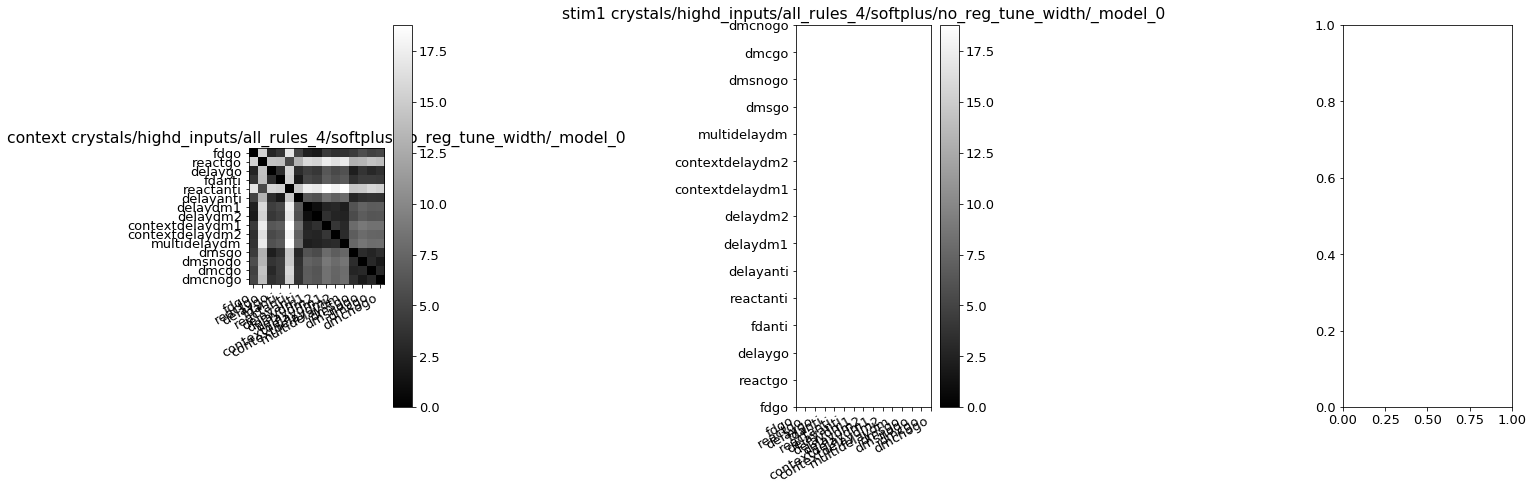

In [5]:
fig = plt.figure(figsize=(21, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})
task_names_sorted = [rules_dict['all'][i] for i in tasks]

ax = plt.subplot(1,len(titles),1)
plt.imshow(X_euc_context,cmap = 'gray')
plt.title(titles[0]+' '+dir_specific+'_model_'+str(model_n))
ax.set_xticks(range(0,len(tasks)))
ax.set_yticks(range(0,len(tasks)))
ax.set_yticklabels(task_names_sorted)
fig.autofmt_xdate()
ax.set_xticklabels(task_names_sorted)
plt.colorbar()

ax = plt.subplot(1,len(titles),2)
# plt.imshow(procrust[titles[1]]['Disparity'],cmap = 'gray', vmin=0, vmax=1)
plt.title(titles[1]+' '+dir_specific+'_model_'+str(model_n))
ax.set_xticks(range(0,len(tasks)))
ax.set_yticks(range(0,len(tasks)))
ax.set_yticklabels(task_names_sorted)
fig.autofmt_xdate()
ax.set_xticklabels(task_names_sorted)
plt.colorbar()

ax = plt.subplot(1,len(titles),3)
plt.imshow(procrust[titles[2]]['Disparity'],cmap = 'gray', vmin=0, vmax=1)
plt.title(titles[2]+' '+dir_specific+'_model_'+str(model_n))
ax.set_xticks(range(0,len(tasks)))
ax.set_yticks(range(0,len(tasks)))
ax.set_yticklabels(task_names_sorted)
fig.autofmt_xdate()
ax.set_xticklabels(task_names_sorted)
plt.colorbar()

fldr = os.path.join('procrustes_analysis/' + dir_specific +'/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

if untrained is True:
    file_name = 'dissim_matrices_'+'model'+str(model_n)+'untrained'
else:
    file_name = 'dissim_matrices_'+'model'+str(model_n)
plt.savefig(fldr + file_name + '.svg')
plt.show()

cmap=plt.get_cmap('tab10')
nD = 10

embedding = MDS(n_components=2, dissimilarity='precomputed')
X_fix_transformed = embedding.fit_transform(X_euc_context)

# embedding = MDS(n_components=2, dissimilarity='precomputed')
# W = procrust[titles[1]]['Disparity']+procrust[titles[1]]['Disparity'].transpose()
# X_stim_transformed = embedding.fit_transform(W/2)

embedding = MDS(n_components=2, dissimilarity='precomputed')
W = procrust[titles[2]]['Disparity']+ procrust[titles[2]]['Disparity'].transpose()
X_go_transformed = embedding.fit_transform(W/2)

fig = plt.figure(figsize=(18, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

ind = 0
for ind in range(len(tasks)):
    r = tasks[ind]
    if r == 0 or r == 3:
        c = cmap(0/10)
    elif r == 1 or r == 4:
        c = cmap(5/10)
    elif r == 11 or r == 12:
        c = cmap(4/10)
    elif r == 18 or r == 19:
        c = cmap(3/10)
    elif r == 16 or r == 17:
        c = cmap(2/10)
    else:
        c = cmap(1/10)
        
    ax = fig.add_subplot(1,len(titles),1)
    plt.plot(X_fix_transformed[ind,0],X_fix_transformed[ind,1],'o',c = c)
    plt.text(X_fix_transformed[ind,0],X_fix_transformed[ind,1],display_names[r],fontsize=16,fontweight='bold',
        bbox={'facecolor':c, 'alpha':0.5, 'pad':2, 'edgecolor':'none'})
    plt.title(titles[0])
    plt.axis('square')
    
    ax = fig.add_subplot(1,len(titles),2)
    plt.plot(X_stim_transformed[ind,0],X_stim_transformed[ind,1],'o',c = c)
    plt.text(X_stim_transformed[ind,0],X_stim_transformed[ind,1],display_names[r],fontsize=16,fontweight='bold',
        bbox={'facecolor':c, 'alpha':0.5, 'pad':2, 'edgecolor':'none'})
    plt.title(titles[1])
    plt.axis('square')
    
    ax = fig.add_subplot(1,len(titles),3)
    plt.plot(X_go_transformed[ind,0],X_go_transformed[ind,1],'o',c = c)
    plt.text(X_go_transformed[ind,0],X_go_transformed[ind,1],display_names[r],fontsize=16,fontweight='bold',
        bbox={'facecolor':c, 'alpha':0.5, 'pad':2, 'edgecolor':'none'})
    plt.title(titles[2])
    plt.axis('square')
    
    ind+=1

plt.title(titles[2] + ' ' + dir_specific+'_model_'+str(model_n))
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.axis('square')

fldr = os.path.join('procrustes_analysis/' + dir_specific +'/')
if not os.path.exists(fldr):
    os.makedirs(fldr)


if untrained is True:
    file_name = 'dissim_map'+str(nD)+'_epoch_'+epoch+'_model_'+str(model_n)+'untrained'
else:
    file_name = 'dissim_map'+str(nD)+'_epoch_'+epoch+'_model_'+str(model_n) 
plt.savefig(fldr + file_name + '.svg')
plt.show()


for epoch in titles[1:3]:
    X = X_euc_context.flatten().reshape(-1, 1)
    y = procrust[epoch]['Disparity'].flatten().reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    Rsqrd = reg.score(X, y)
    
    plt.plot(X,y,'.')
    plt.plot(np.sort(X,axis = 0),reg.predict(np.sort(X,axis = 0)),'-k')
    plt.title(dir_specific+'_model_'+str(model_n))
    plt.xlabel('fix disparity')
    plt.ylabel(epoch + ' disparity')
    plt.text(.6*np.max(X),.1*np.max(y),'R^2 = ' + '{0:.2f}'.format(Rsqrd))


    if untrained is True:
        file_name = 'fix_v_'+ epoch + '_' + str(nD) + '_epoch_'+ epoch +'_model_'+str(model_n)+'untrained'
    else:
        file_name = 'fix_v_'+ epoch + '_' + str(nD) + '_epoch_'+ epoch +'_model_'+str(model_n)
    
    np.save(fldr + file_name + '.npy', Rsqrd)
    plt.savefig(fldr + file_name + '.svg')
    plt.show()
